# [AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE](https://arxiv.org/pdf/2010.11929.pdf)

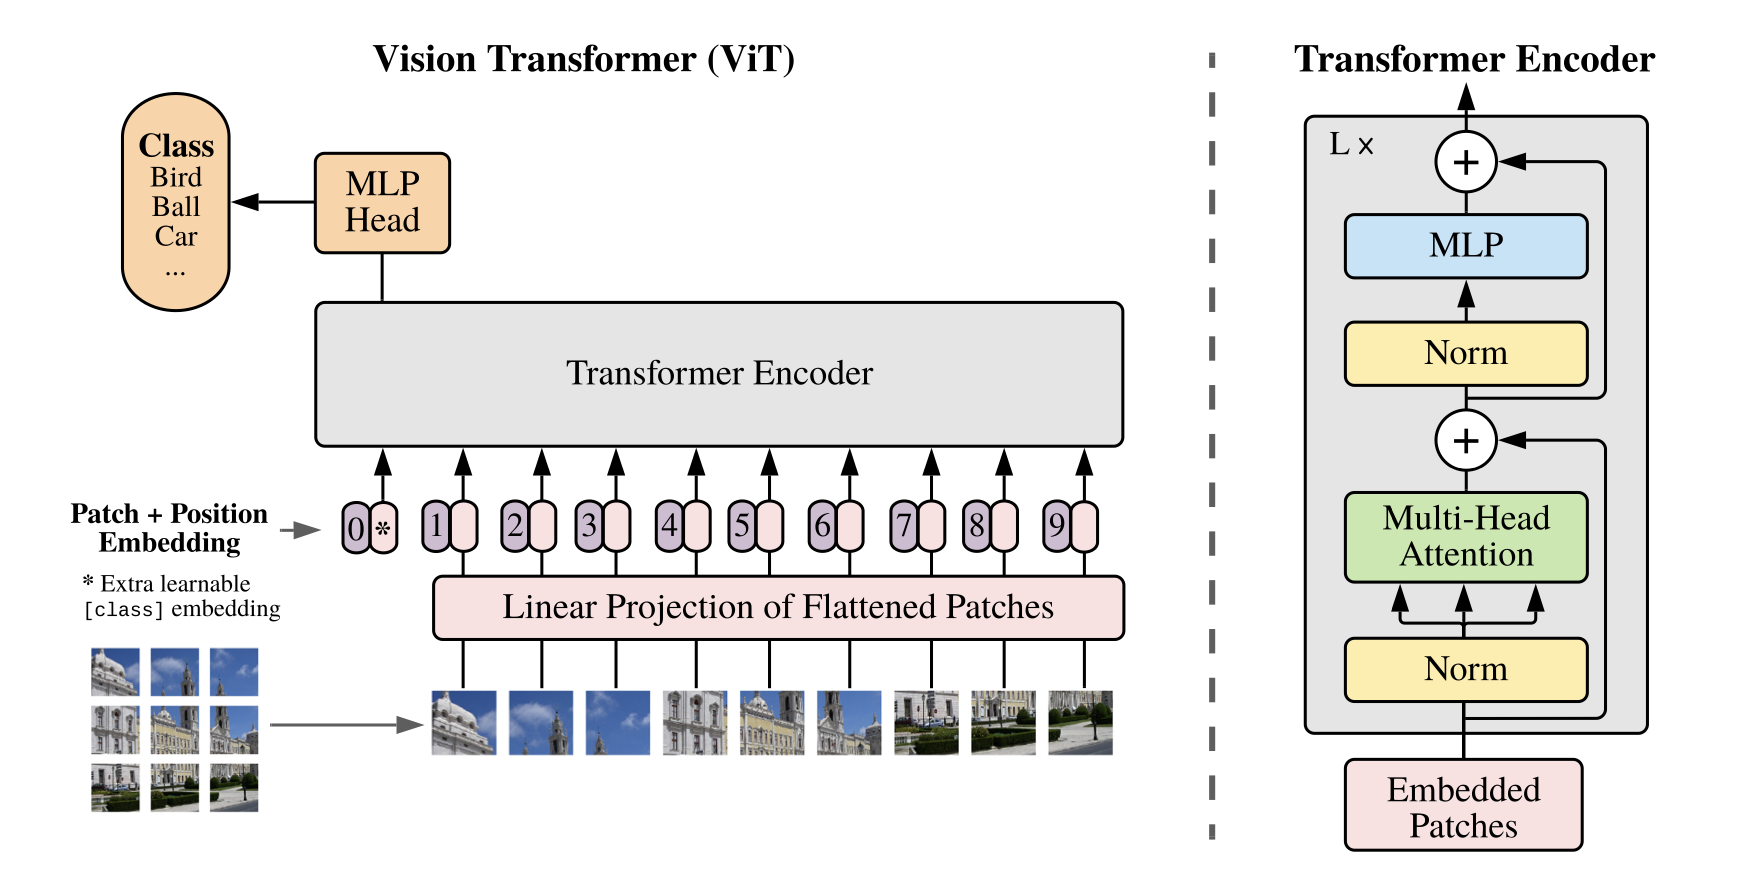

In [235]:
import torch
from torch import nn
from torch import tensor
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import pickle
import os
from datasets import load_dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Creating Image Patches

In [237]:
from PIL import Image

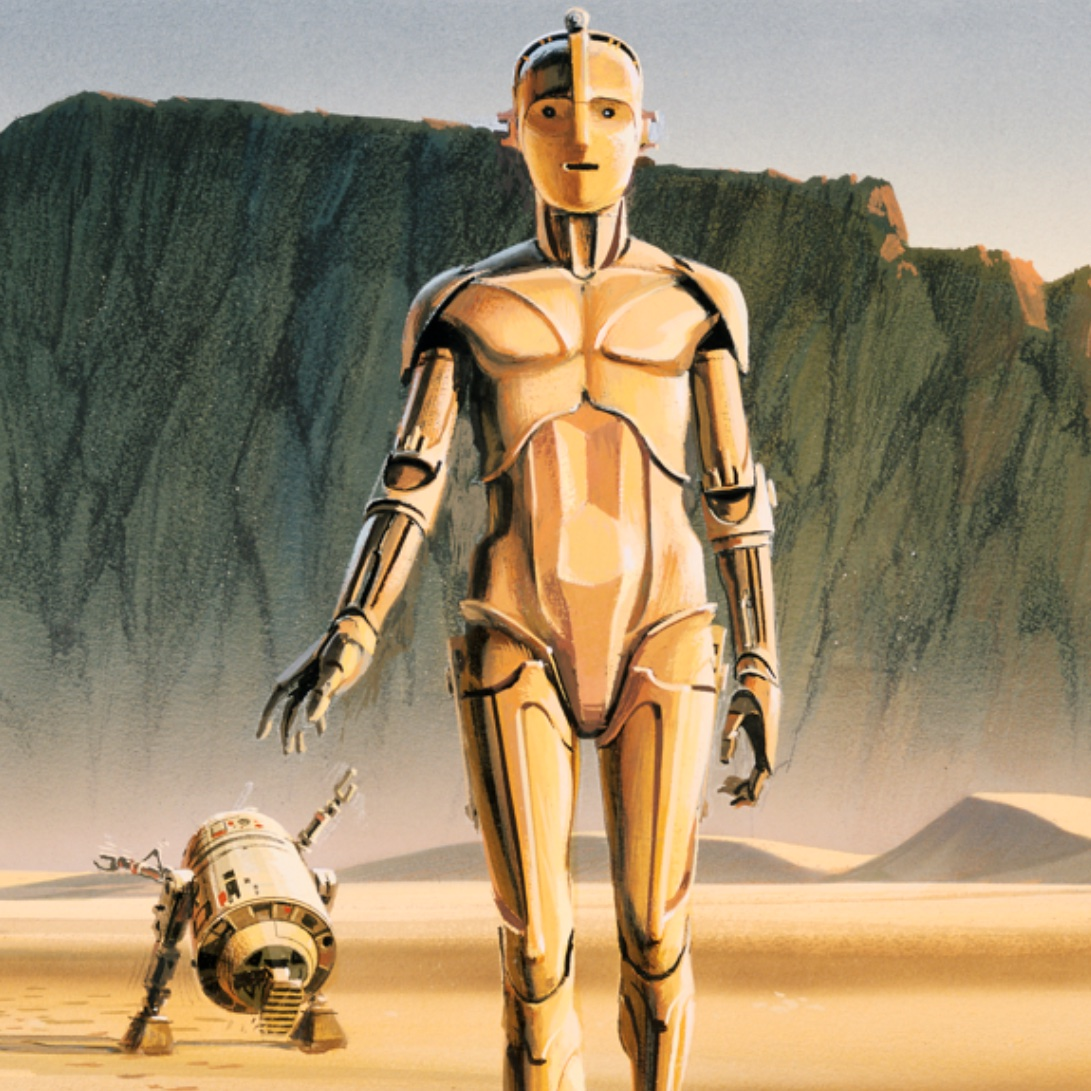

In [289]:
dummy_img = Image.open("images/dummy_img.jpg")
dummy_img

In [290]:
dummy_img.size

(1091, 1091)

In [288]:
dummy_img.reduce((64, 64))

In [ ]:
to_tensor = transforms.Compose([transforms.PILToTensor()])
dummy_data = to_tensor("images/dummy_img.png").to(torch.float32)

In [382]:
dummy_img = torch.arange(0, 64**2).float()
# std = torch.std(dummy_img)
# mean = torch.mean(dummy_img)
# dummy_img = ((dummy_img-mean)/std).view((64, 64)).unsqueeze(2)
min_ = torch.min(dummy_img)
max_ = torch.max(dummy_img)
dummy_img = ((dummy_img-min_)/max_).view((64, 64)).unsqueeze(2) # Normalize to be between [0, 1]
dummy_img = torch.concat([dummy_img, dummy_img, dummy_img], dim=-1)

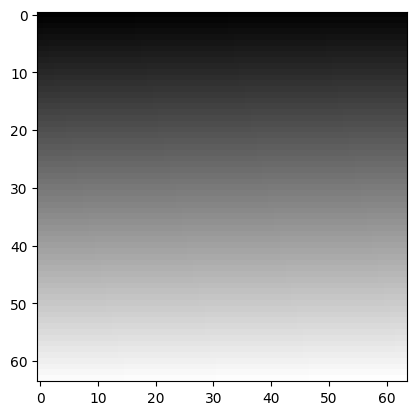

In [383]:
plt.imshow(dummy_img);

In [369]:
class Patchify():
    def __init__(self):
        pass
    
    @staticmethod
    def reshape(img:tensor, patch_width:int, patch_height:int, padder=0):
        """
        param: img          : the image tensor of a 3D shape
        param: patch_width  : the patch width
        param: patch_height : the patch heigh
        param: padder       : the value to use if the image is not not of size width*hieght
        """
        assert len(img.shape) == 3, "Function assumes shape (width, height, channel)"
        width, height, channels = img.shape
        
        pad_width = width % patch_width
        pad_height = height % patch_height
        padded_img = np.pad(img, ((0, pad_width), (0, pad_height), (0, 0)), mode='constant')
                
        patches = []
        for i in range(0, padded_img.shape[0], patch_width):
            for j in range(0, padded_img.shape[1], patch_height):
                patch = padded_img[i:i+patch_width, j:j+patch_height, :]
                patches.append(patch)
        return tensor(np.array(patches))

In [388]:
patched_dummy_img = Patchify.reshape(dummy_img, 16, 16)
patched_dummy_img.shape

torch.Size([16, 16, 16, 3])

Patched dummy image:


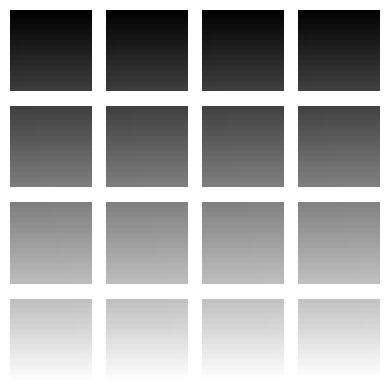

In [389]:
num_patches, patch_width, patch_height, _ = patched_dummy_img.shape
num_rows = int(np.sqrt(num_patches))
num_cols = int(np.sqrt(num_patches))
assert num_patches == num_rows * num_cols, "Number of patches should be 16"

print("Patched dummy image:")
fig, axs = plt.subplots(num_rows, num_cols, figsize=(4,4))
for i in range(num_rows):
    for j in range(num_cols):
        idx = i * num_cols + j
        ax = axs[i][j]
        ax.imshow(patched_dummy_img[idx])
        ax.axis('off')

plt.tight_layout()
plt.show()

# Positional Embeddings:

Besause transformers are natively not able to distinguish between the permutations of an input sequence (i.e. \[1, 2, 3\] is the same as \[2, 1, 3\] and \[3, 2, 1\]), we need to provide positional embeddings so it becomes spatially aware.
</br></br>
In this paper, the embeddings are applied to each of the image patches

In the paper, they only go over how they used 1D embeddings (2D embeddings didn't help out very much); however, they did NOT specify the kind of positional embedding they used, so we are going to try 2 types of embeddings that are known to be useful for vision transformers:
1. [Rotary Embeddings](https://arxiv.org/abs/2104.09864) (aka RoPE)
    - A good [article](https://blog.eleuther.ai/rotary-embeddings/) on the topic
    - Check out [RoFormer](https://github.com/ZhuiyiTechnology/roformer) as well to see how it was implemented
2. TBD

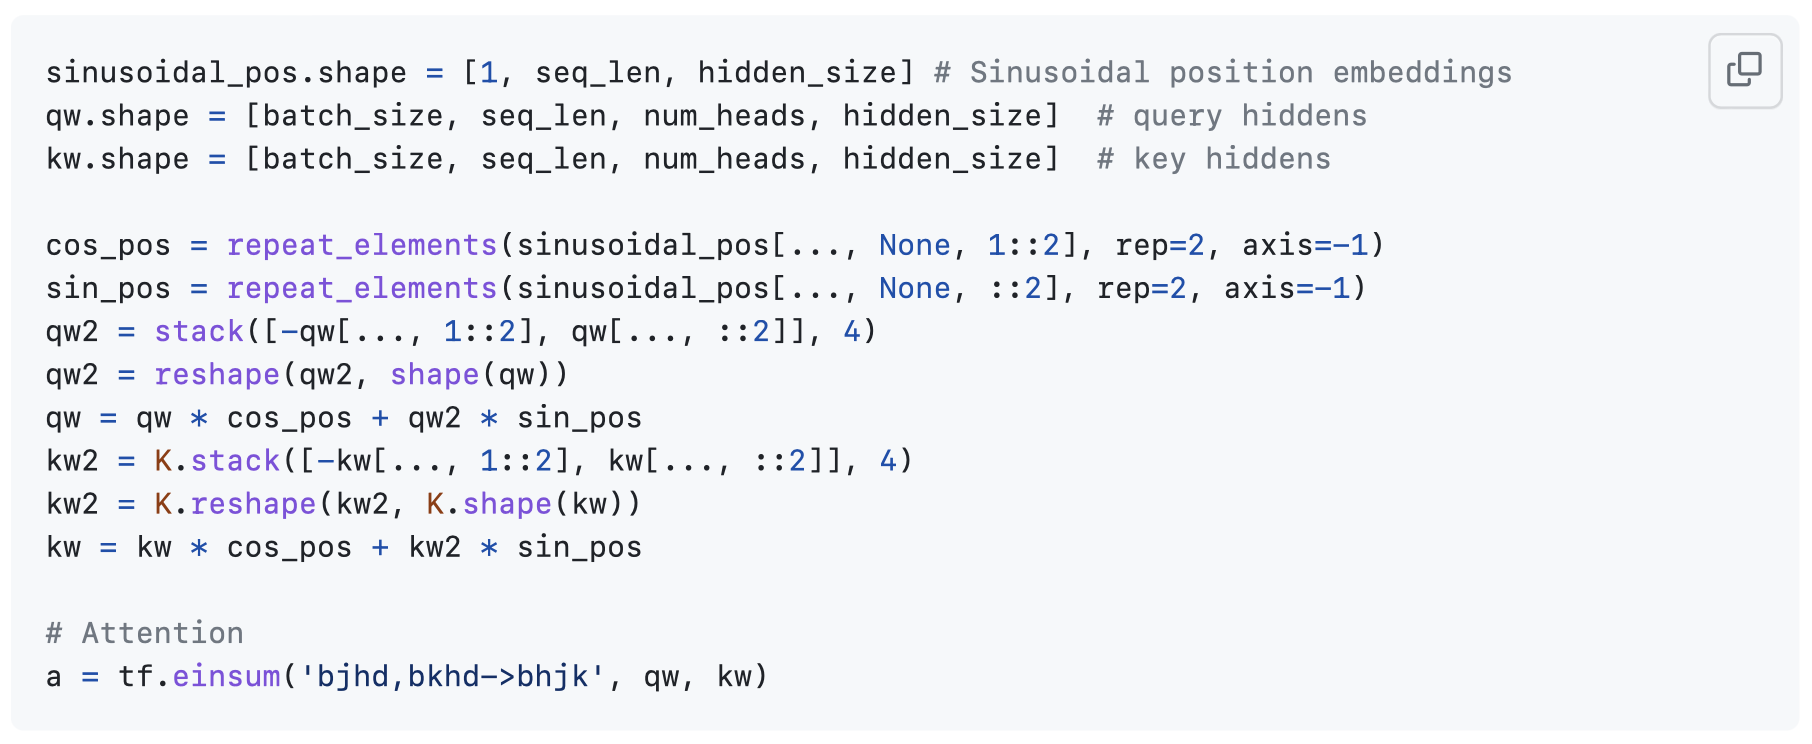

In [450]:
class RotaryPositionalEmbeddings():
    def __init__(self, 
               max_seq_length:int, 
               model_dim:int, 
               scale_context_length = False,
               base = 10000,
               alpha = 8
              ):
        self.positional_encodings = None
        
        # NOTE: the sequence length is the number of patches plus 1 for a special 'class'
        self.max_seq_length = max_seq_length
        self.model_dim = model_dim
        

        
        scale_context_length = False # WARNING: I'm like 30% sure this is implemented INCORRECTLY currently, so let's not use it for now
        if scale_context_length:
            self.sin, self.cos = self.sinusoidal_embeddings_llama(base, alpha)
        else:
            self.sin, self.cos = self.sinusoidal_embeddings()
                
    # There's an option to scale the rotary embeddings to take in much longer (up to ~4x) context lengths
    # Refernce https://www.reddit.com/r/LocalLLaMA/comments/14lz7j5/ntkaware_scaled_rope_allows_llama_models_to_have/
    # Also look at https://github.com/JunnYu/RoFormer_pytorch/blob/roformer_v2/src/roformer/modeling_roformer.py
    # WARNING: I'm like 30% sure this is implemented INCORRECTLY currently, so let's not use it for now
    # Credit: https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py
    def sinusoidal_embeddings_llama(self, base, alpha):
        base = base * np.power(a, (self.model_dim / (self.model_dim-2)))
        frequencies = (torch.arange(0, self.model_dim, 2).float() / self.model_dim)
        frequencies = 1.0 / (np.power(base, frequencies))
        frequencies = torch.matmul(torch.arange(self.model_dim).float().unsqueeze(1), frequencies.unsqueeze(1).T)
        frequencies_cat = torch.cat((frequencies, frequencies), dim=-1)
        return (frequencies_cat.sin(), frequencies_cat.cos())
        
        
    def sinusoidal_embeddings(self):
        positions = torch.arange(0, self.max_seq_length).float().unsqueeze(1)
        
        div_func = lambda i: np.power(10000, (i / self.model_dim))
        divisor = torch.arange(0, self.model_dim, 2).float().apply_(div_func)
        
        sin = torch.sin(positions / divisor)
        cos = torch.cos(positions / divisor)
        
        sin = torch.cat([sin, sin], dim=-1)
        cos = torch.cat([cos, cos], dim=-1)
        
        return (sin, cos)
    
    # Credit: https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py
    def rotate_half(x):
        """Rotates half the hidden dims of the input."""
        x1 = x[:, : x.shape[-1] // 2]
        x2 = x[:, x.shape[-1] // 2 :]
        return torch.cat((-x2, x1), dim=-1)
    
    def __call__(self, x):
        # NOTE: this gets applied to the Queries and Keys at the Attention block
        
        # Need to handle case where x is accidently longer than max sequence length:
        # if x.shape[1] > self.max_seq_length:
        #      self.model_dim = x.shape[1]
        #      self.sinusoidal_embeddings()
        
        assert len(x.shape) == 2, "'x' needs to be of shape (sequence_length, model_dimension)"
        
        x2 = rotate_half(x)
        return (x * self.cos[:x.shape[0], :]) + (x2 * self.sin[:x.shape[0], :])
        
        
        

In [451]:
# class PositionalEncodings():
#     def __init__(self, patch_height:int, patch_width:int, num_patches:int):
#         # Note: num_patches = sequnce length
#         # The encodings here are 1-dimensional as they didn't find any additional benefit from 2D aware encodings
        
#         patch_dimension = patch_height*patch_width
#         positional_encodings = torch.ones(size=(num_patches, patch_dimension)).float()

#         positions = torch.arange(0, patch_dimension).float().unsqueeze(1)
#         i = torch.arange(0, patch_width, 2)

#         div_func = lambda i: np.power(10000, (i / patch_dimension))
#         divisor = torch.arange(0, patch_dimension, 2).float().apply_(div_func)
#         sin = torch.sin(positions / divisor)
#         cos = torch.cos(positions / divisor)

#         positional_encodings[:, 0::2] = sin
#         positional_encodings[:, 1::2] = cos
        
#         positional_encodings = positional_encodings.view(num_patches, patch_height, patch_width)
#         device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#         self.positional_encodings = positional_encodings.to(device)
        

In [514]:
class LlamaRotaryEmbedding(torch.nn.Module):
    def __init__(self, dim, max_position_embeddings=2048, base=10000, device=None):
        super().__init__()

        self.dim = dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base
        inv_freq = 1.0 / (self.base ** (torch.arange(0, self.dim, 2).float().to(device) / self.dim))
        self.register_buffer("inv_freq", inv_freq, persistent=False)

        # Build here to make `torch.jit.trace` work.
        self._set_cos_sin_cache(seq_len=max_position_embeddings)

    def _set_cos_sin_cache(self, seq_len):
        self.max_seq_len_cached = seq_len
        t = torch.arange(self.max_seq_len_cached)

        freqs = torch.einsum("i,j->ij", t, self.inv_freq)
        # Different from paper, but it uses a different permutation in order to obtain the same calculation
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer("cos_cached", emb.cos()[None, None, :, :].float(), persistent=False)
        self.register_buffer("sin_cached", emb.sin()[None, None, :, :].float(), persistent=False)

    def forward(self, x, seq_len=None):
        # x: [bs, num_attention_heads, seq_len, head_size]
        if seq_len > self.max_seq_len_cached:
            self._set_cos_sin_cache(seq_len=seq_len)

        return (
            self.cos_cached[:, :, :seq_len, ...].float(),
            self.sin_cached[:, :, :seq_len, ...].float(),
        )

In [517]:
def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, cos, sin, position_ids):
    # The first two dimensions of cos and sin are always 1, so we can `squeeze` them.
    cos = cos.squeeze(1).squeeze(0)  # [seq_len, dim]
    sin = sin.squeeze(1).squeeze(0)  # [seq_len, dim]
    cos = cos[position_ids].unsqueeze(1)  # [batch_size, 1, seq_len, dim]
    sin = sin[position_ids].unsqueeze(1)  # [batch_size, 1, seq_len, dim]
    q_embed = (q * cos) + (rotate_half(q) * sin)
    return q_embed

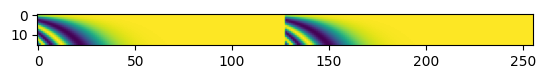

In [518]:
r = LlamaRotaryEmbedding(dim=256, max_position_embeddings=16)
plt.imshow(r.cos_cached[0, 0]);

In [533]:
r.cos_cached.squeeze(1).squeeze(0)[0:20].unsqueeze(1).shape

torch.Size([16, 1, 256])

In [519]:
plt.imshow(apply_rotary_pos_emb(reshapped_patched_dummy_img, r.cos_cached, r.sin_cached));

TypeError: apply_rotary_pos_emb() missing 1 required positional argument: 'position_ids'

In [505]:
reshapped_patched_dummy_img.shape

torch.Size([16, 256, 3])

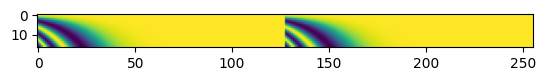

In [480]:
plt.imshow(dummy_RoPE.cos);

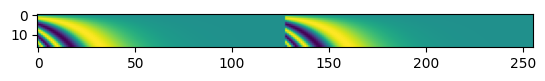

In [481]:
plt.imshow(dummy_RoPE.sin);

In [469]:
model_dim = 512
num_heads = 8
dummy_RoPE = RotaryPositionalEmbeddings(
    max_seq_length = patched_dummy_img.shape[0] + 1, # Add in 1 for the class label
    model_dim = 256,
    scale_context_length=False
)

# Need to reshape to each patch is flattened
num_patches, patch_w, patch_h, num_channels = patched_dummy_img.shape
reshapped_patched_dummy_img = patched_dummy_img.view(num_patches, patch_w*patch_h*num_channels)

positionally_encoded_dummy_img = dummy_RoPE(reshapped_patched_dummy_img)
positionally_encoded_dummy_img

torch.Size([16, 256])

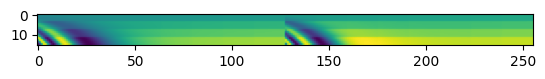

In [535]:
plt.imshow(positionally_encoded_dummy_img);

# Attention block:

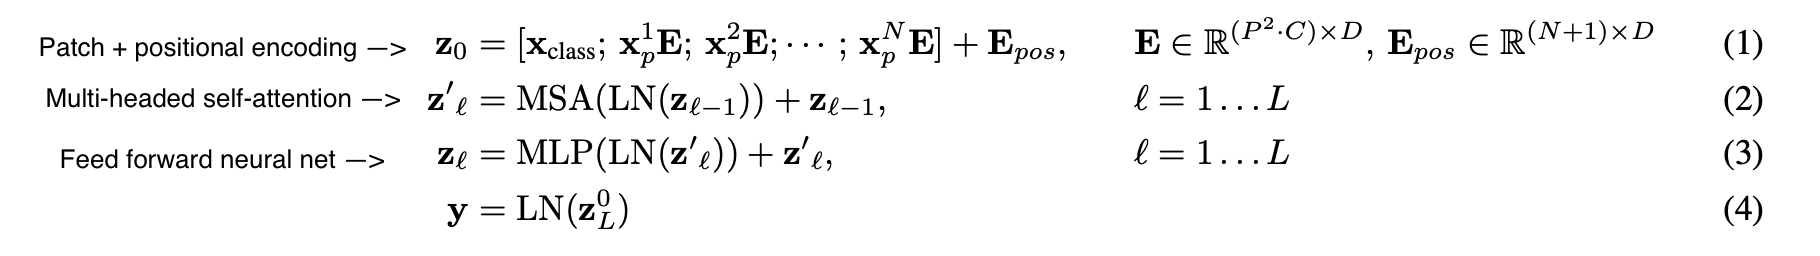

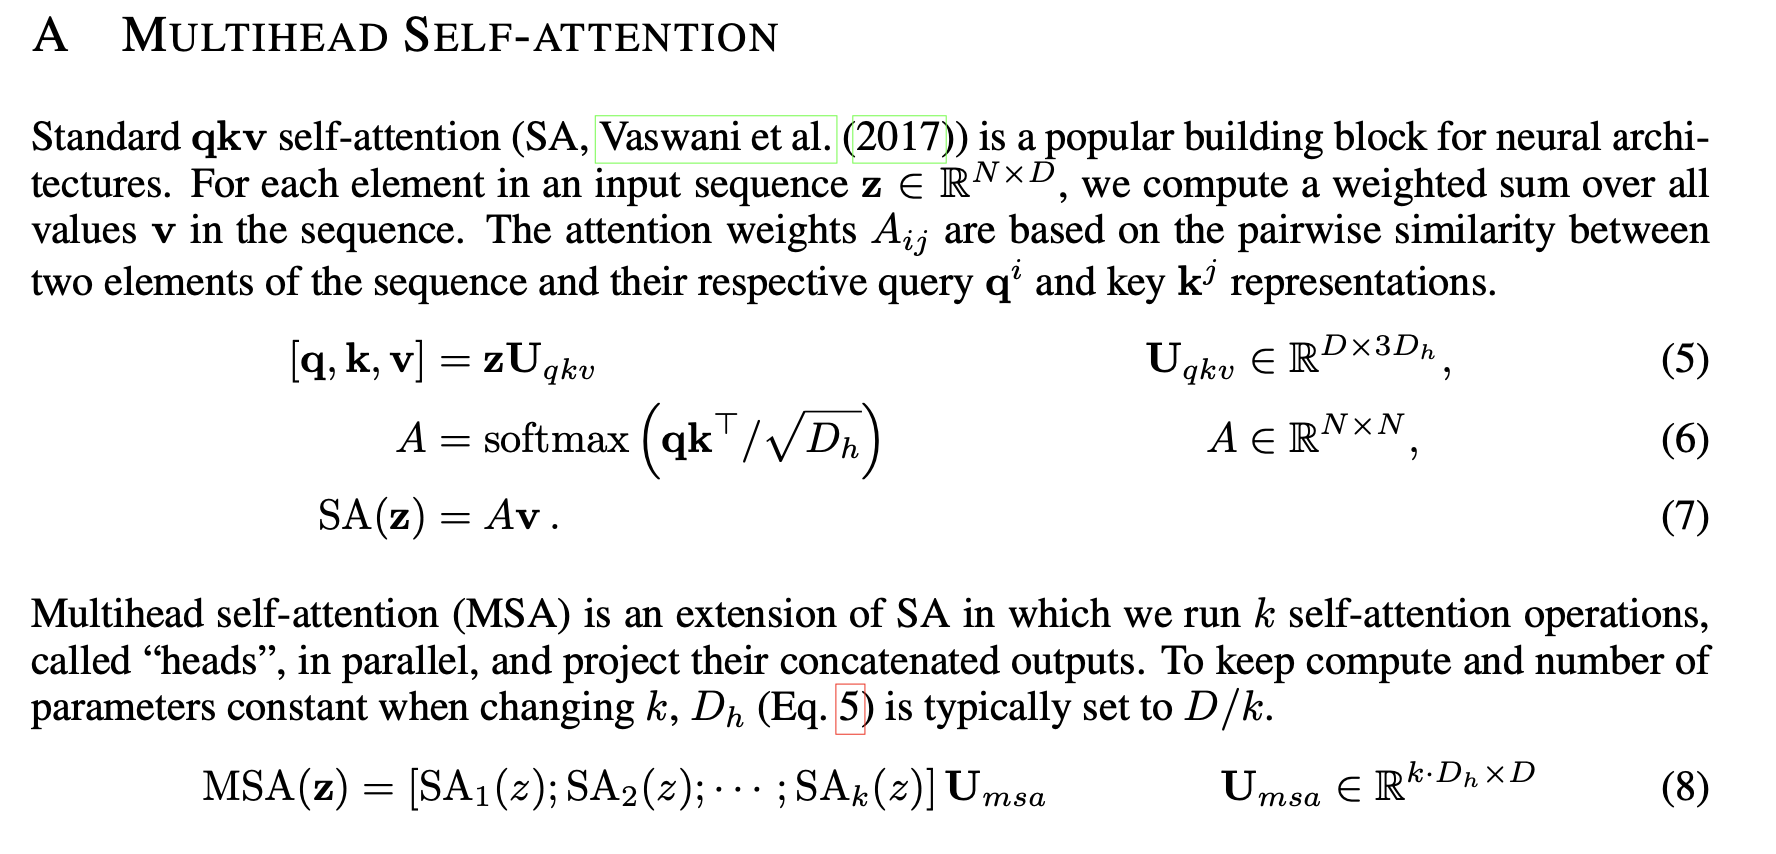

### Axial Self-Attention:
- Instead of doing attention along a 1-D vector like in text, they preform attention along each axis (excluding color channel axis).
    - This means for each attention block, there is a row attention + feed forward network block AND and column attention + feed forward network block

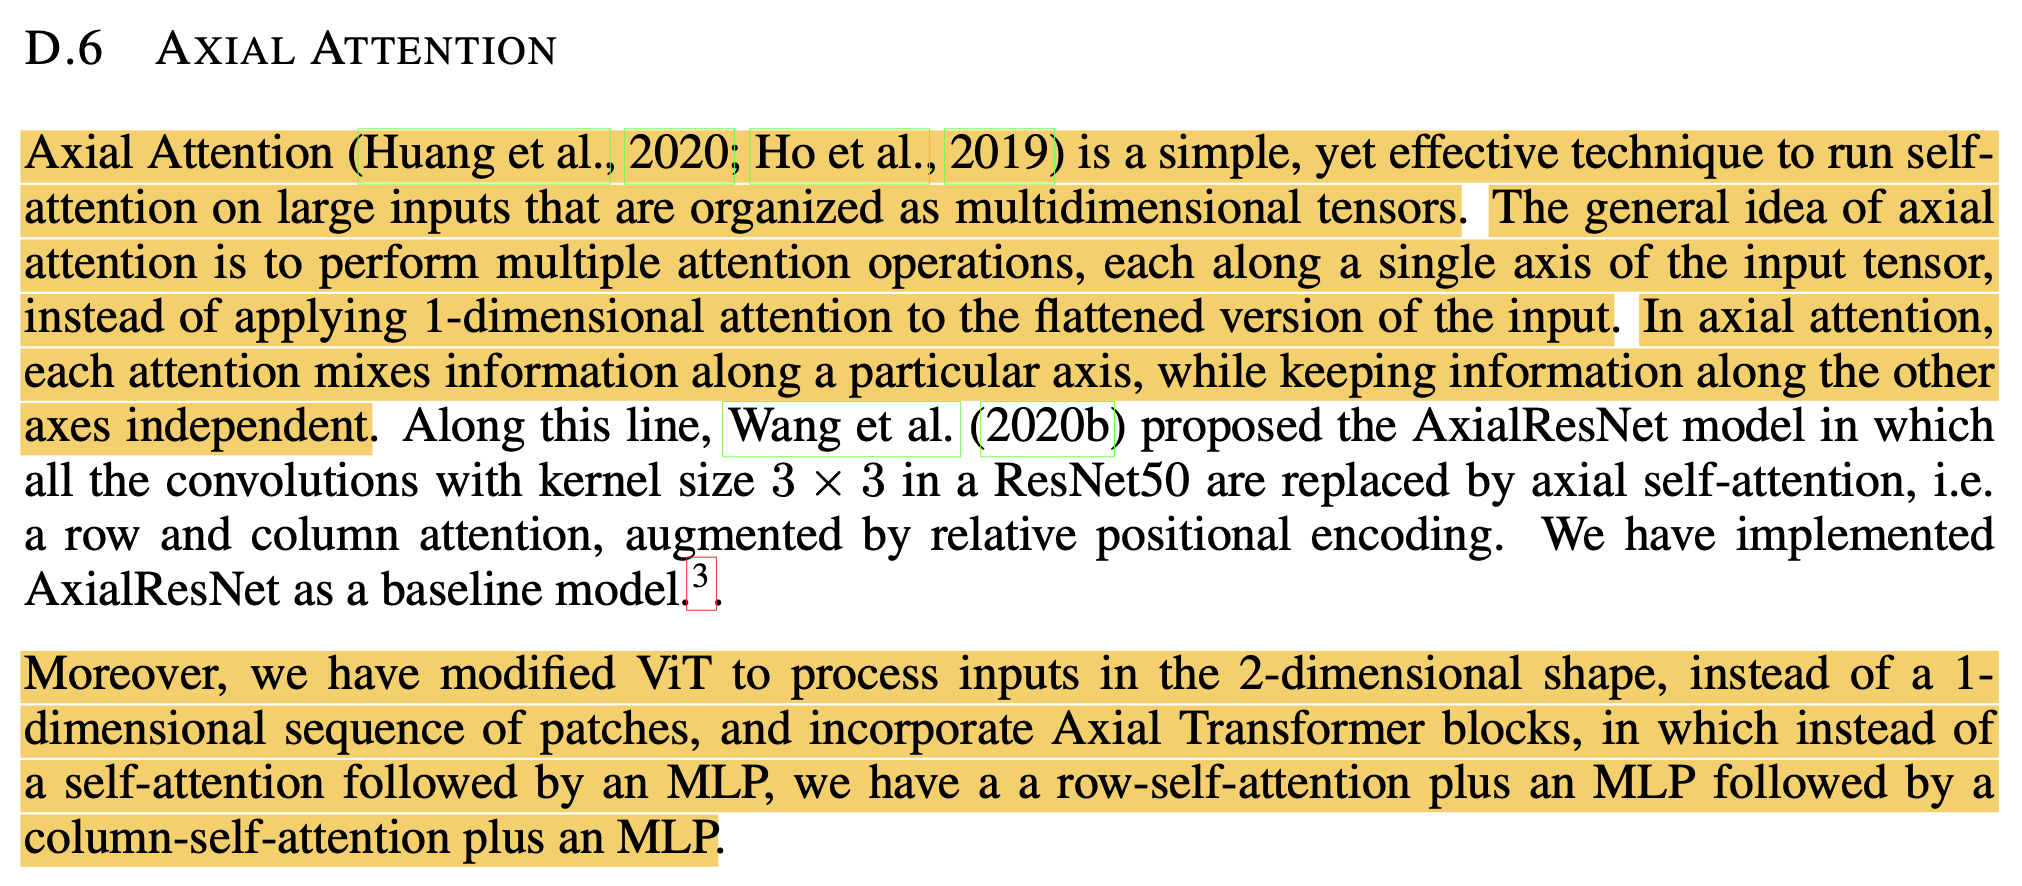

In [4]:
class ScaledDotProductAttention():
    def __init__(self):
        pass
    
    @staticmethod
    def attn(Q:tensor, K:tensor, V:tensor, mask=None) -> tensor:        
        if len(K.shape)==4: # handle for if it's a matrix instead of a vector
            scale = np.sqrt(K.shape[-1])
            attention_values = torch.matmul(Q, K.transpose(-2, -1))/scale
        else:  
            scale = np.sqrt(K.shape[0])
            attention_values = torch.matmul(Q, K.T)/scale
        
        if mask is not None:
            # unsqueeze to add extra dimensions
            if len(mask.shape) == 2:
                mask = mask.unsqueeze(1).unsqueeze(2)
            attention_values = attention_values.masked_fill(mask == 0, -1e9)
            
        softmax = F.softmax(attention_values, dim=-1)
        
        output = torch.matmul(softmax, V)
        
        # output shape: batch_size, num_heads, seq_length, head_dim
        return output

In [5]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, model_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        assert model_dim % num_heads == 0, "Model must have a dimension divisible by # of heads."
        
        self.model_dim = model_dim
        self.num_heads = num_heads
        self.head_dim = model_dim // num_heads
        
        # Need to learn Q, K, V weights
        self.wQ = nn.Linear(model_dim, model_dim)
        self.wK = nn.Linear(model_dim, model_dim)
        self.wV = nn.Linear(model_dim, model_dim)
        self.wOut = nn.Linear(model_dim, model_dim)
                
    def forward(self, X, RoPE:RotaryPositionalEmbeddings, Q=None, mask=None):
        # Q is option for decoder layer for cross-attention
        
        batch_size, seq_length, model_dim = X.size()
        if Q is not None:
            batch_size, seq_length, model_dim = Q.size()
                
        Q, K, V = self.wQ(X) if Q is None else self.wQ(Q), self.wK(X), self.wV(X)
        
        # Need to reshape as (batch_size, num_heads, seq_length, head_dim)
        def reshape(inp_tensor):
            batch_size, seq_length, model_dim = inp_tensor.size()
            return inp_tensor.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        
        Q, K, V = RoPE(reshape(Q)), RoPE(reshape(K)), reshape(V)

        attention_values = ScaledDotProductAttention.attn(Q, K, V, mask)
        comb_attn = attention_values.transpose(1, 2).contiguous()
        comb_attn = comb_attn.view(batch_size, seq_length, model_dim)
        
        # Final linear layer. Shape (batch_size, seq_length, model_dim)
        output = self.wOut(comb_attn)
        return output

# Encoder - Decoder
- Copied mostly from my transformer noteboote

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, RoPE:RotaryPositionalEmbeddings, 
                 model_dim:int=512,
                 axis_numbers:int=3,
                 num_heads:int=8, 
                 ff_dim:int=2048, 
                 dropout=0.1
                ):
        """
        param: model_dim: the dimension of the attention mechanism (original paper is 512)
        param: num_heads: the number of attention layer heads to have (original paper is 8)
        param: ff_dim: the dimension of of the feed forward layer (original paper is 2048)
        param: dropout: the dropout rate for each of the layers (original paper is 0.1)
        """
        super(EncoderBlock, self).__init__()
        self.model_dim = model_dim
        
        nn.ModuleList([
            nn.Sequential([
                MultiHeadSelfAttention(model_dim, num_heads),
                nn.LayerNorm(model_dim),
                PositionwiseFeedForward(model_dim, ff_dim),
                nn.LayerNorm(model_dim)
            ])  
            for _ in range(axis_numbers)
        ])
        
        self.attention_layer = MultiHeadSelfAttention(model_dim, num_heads)
        self.attention_layer_norm = nn.LayerNorm(model_dim)
        # Comperable to batch norm, that computes the mean and variance of a batch,
        # LayerNorm computes the mean and variance used for normalization from a single "body"
        # which in the above case is the mean and norm for the output attention layer matrix
        
        self.ffn = PositionwiseFeedForward(model_dim, ff_dim)
        self.ffn_norm = nn.LayerNorm(model_dim)
        
        # Original paper also applies a dropout to each sublayer of P(dropout) = 0.1
        self.dropout = nn.Dropout(dropout)
        
        self.RoPE = RoPe
                
    def forward(self, X, mask=None):
        # LayerNorm(X + SubLayer(X))
                        
        X = self.attention_layer_norm(X + self.dropout(self.attention_layer(X, mask=mask, RoPE=self.RoPE)))
        
        X = self.ffn_norm(X + self.dropout(self.ffn(X)))
        
        return X

## Dataset

The paper used Google's own JFT-300M dataset (as well as some others). This dataset is not released to the public, and I, as an individual, do not have the time/patience/desire to label 300,000,000 images... life is worth living 😵‍💫😵‍💫😵‍💫😵‍💫
</br></br>
Thus, I will use a smaller dataset: a subset of the Asirra cats vs dogs dataset
</br></br>
@Inproceedings (Conference){
</br>
asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
</br>
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
</br>
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
</br>
booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
</br>
year = {2007},
</br>
month = {October},
</br>
publisher = {Association for Computing Machinery, Inc.},
</br>
url = {https://www.microsoft.com/en-us/research/publication/asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization/},
</br>
edition = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
</br>
}

**Note:** Visual transformers are meant to only be trained on very large datasets (14M-300M images), so expect poor preformance 😬
- **Quote from paper:** "When trained on mid-sized datasets such as ImageNet without strong regularization, these models yield modest accuracies of a few percentage points below ResNets of comparable size. This seemingly discouraging outcome may be expected: Transformers lack some of the inductive biases inherent to CNNs, such as translation equivariance and locality, and therefore do not generalize well when trained on insufficient amounts of data. ... However, the picture changes if the models are trained on larger datasets (14M-300M images). We find that large scale training trumps inductive bias"

**Note:** In the original paper, they use 224 x 224 images with patch sizes of 16 or 32. We'll be doing a very similar image shape

**Note:** We will not be using greyscale. I want this excersize to be done with channels so it could be extended to hyperspectral images. All images will be normalized, though.

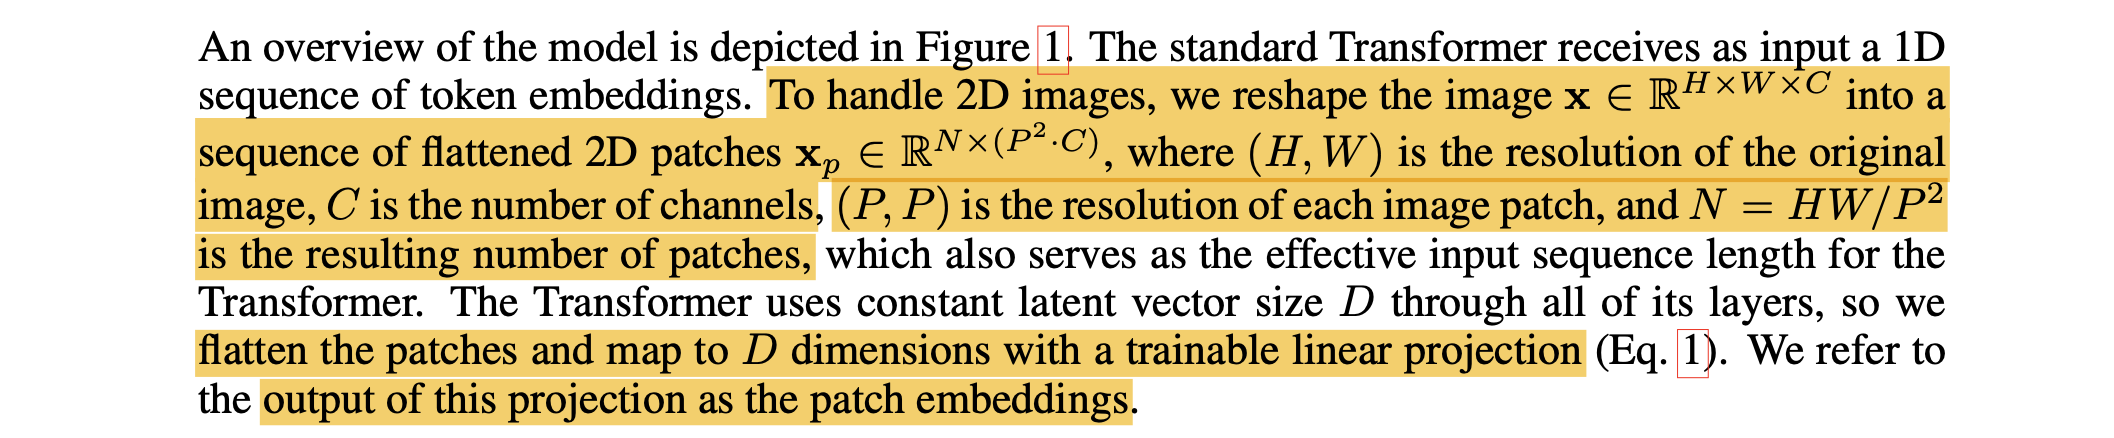

In [163]:
dataset = load_dataset("cats_vs_dogs", split='train')

Found cached dataset cats_vs_dogs (/Users/makiper/.cache/huggingface/datasets/cats_vs_dogs/default/1.0.0/d4fe9cf31b294ed8639aa58f7d8ee13fe189011837038ed9a774fde19a911fcb)


In [164]:
dataset = dataset.shuffle()

Shape: (288, 384)


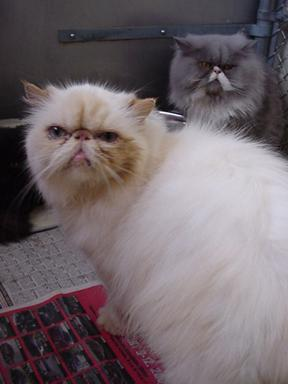

In [165]:
print("Shape:", dataset[0]['image'].size)
dataset[0]['image']

In [166]:
normalized_img_example = None

def preprocess_data(data, resize:tuple=(224, 224), normalize=True) -> list:
    global normalized_img_example
    
    to_tensor = transforms.Compose([transforms.PILToTensor()])
    
    processed_data = []
    processing_errors = 0 # these are typically cuased when std is 0
    for d in tqdm(data):
        img_tensor = to_tensor(d['image']).to(torch.float32)
        
        try:
            channel_means = img_tensor.mean([1, 2]) # 3 means - 1 for each channel
            channel_stds = img_tensor.std(dim=[1, 2]) # 3 standard deviations - 1 for each channel

            if normalize:
                normalize = transforms.Compose([
                                            transforms.Normalize(channel_means, channel_stds),
                                            transforms.Resize(resize, antialias=True),
                                            #     transforms.RandomHorizontalFlip(),  # If desired for cheap dataset robustness, apply random horizontal flip
                                            #     transforms.RandomRotation(10),  # If desired for cheap dataset robustness, apply random rotation by up to 10 degrees
                                            ])
                img_tensor = normalize(img_tensor)
                
                if normalized_img_example is None:
                    normalized_img_example = img_tensor
                
            # Reshape into patches
            C, H, W = img_tensor.shape
            Patch_Size = int(np.sqrt(H)) # Patch sizes are square in the paper - do they need to be? Probably not
            N = int((H*W)/Patch_Size**2)
            
            img_tensor = img_tensor.view(N, (C*Patch_Size**2))

            processed_data.append({'image': img_tensor, 'labels':d['labels']})
            
        except ValueError as v:
            processing_errors += 1
            continue
    print(f"Number of 'ValueError's occured: {processing_errors}")
    
    return processed_data

In [167]:
dataset = preprocess_data(dataset)

100%|█| 23410/23410 

Number of 'ValueError's occured: 1


In [168]:
training_dataset = dataset[:-1000]
testing_dataset = dataset[-1000:]

In [169]:
print(f"Training length: {len(training_dataset)} | Testing length: {len(testing_dataset)}")

Training length: 22409 | Testing length: 1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


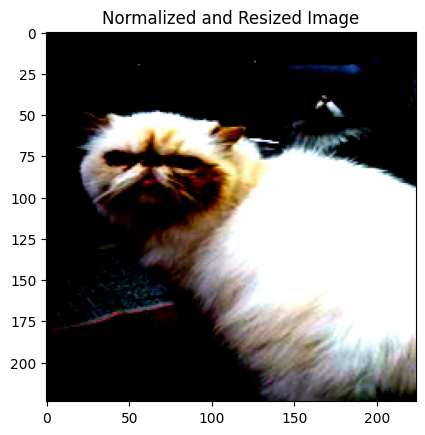

In [170]:
plt.title("Normalized and Resized Image");
plt.imshow(normalized_img_example.permute(1, 2, 0));

In [177]:
training_dataset[0]['image'].shape

torch.Size([256, 588])